In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import itertools
import scipy.io
import sys
import seaborn as sns
import sklearn
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import math
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import KBinsDiscretizer
import warnings
from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning
plt.style.use('classic')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Konstanti

signal_length = 350
num_signals = 8
sampling_rate = 250
sample_freq = 250
sample_duration = 1.4
time = np.arange(0.0, sample_duration, 1/sample_freq)

events_per_run=8
train_blocks=20
train_runs_per_block=10

train_num_events = train_blocks*train_runs_per_block*events_per_run   #(20*10*8=1600)

electrodes = ['C3','CZ','C4','CPz','P3','Pz','P4','POz']
features = ['pos_peak_period','neg_peak_period','alpha_channel','delta_channel']
columns = [electrode+"_"+feature for electrode in electrodes for feature in features]

temp_channels=['alpha_channel','delta_channel']
channels = [electrode+"_"+channel for electrode in electrodes for channel in temp_channels]

In [ ]:
# Vcituvanje na raw train podatoci
def loading_train_data(subject_num):
  path="drive/My Drive/Inteligentni_Sistemi/SBJ"

  train_data_01 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S01/Train/trainData.mat')['trainData']
  train_events_01 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S01/Train/trainEvents.txt')
  train_targets_01 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S01/Train/trainTargets.txt')

  train_data_02 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S02/Train/trainData.mat')['trainData']
  train_events_02 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S02/Train/trainEvents.txt')
  train_targets_02 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S02/Train/trainTargets.txt')

  train_data_03 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S03/Train/trainData.mat')['trainData']
  train_events_03 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S03/Train/trainEvents.txt')
  train_targets_03 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S03/Train/trainTargets.txt')

  train_data ={ "S01": (train_data_01, train_events_01, train_targets_01),
                "S02": (train_data_02, train_events_02, train_targets_02),
                "S03": (train_data_03, train_events_03, train_targets_03)
               }
  return train_data

In [ ]:
# Reformat na train podatocite

def reformat(set_data):
  (train_data, train_events, train_targets) = set_data
  df = np.array([a[i] for i in range(0,1600) for sublist in train_data for a in sublist])
  df_1600 = np.array([df[i:i+2800] for i in range(0,len(df),2800)])
  data = np.zeros(shape=(train_num_events,num_signals,signal_length))
  for i in range(len(df_1600)):
    subset = df_1600[i]
    data[i] = [subset[i:i+350] for i in range(0,len(subset),signal_length)]
  
  return data

Text(0, 0.5, 'signal')

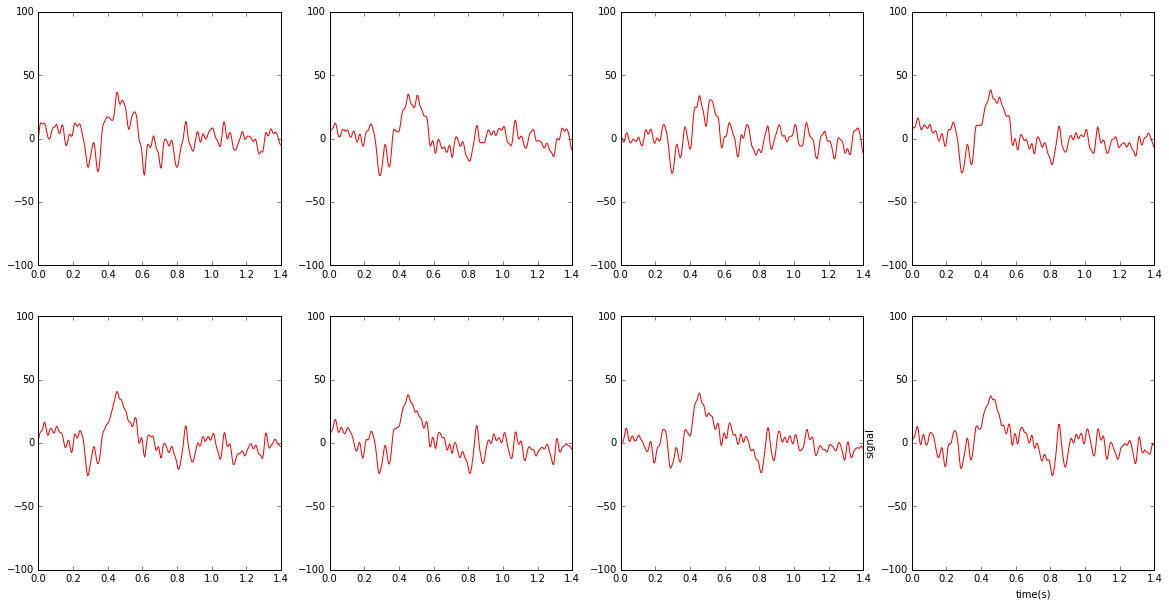

In [ ]:
# Plot za sekoj od 8te signali za prviot nastan
tr_data = reformat(loading_train_data(15)["S01"])

# print(tr_data)
sample_freq = 250
sample_duration = 1.4
fig = plt.figure(figsize=(20,10))
time = np.arange(0.0, sample_duration, 1/sample_freq)
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.ylim([-100, 100])
    plt.plot(time,tr_data[7][i-1],color='red')
plt.xlabel('time(s)')
plt.ylabel('signal')

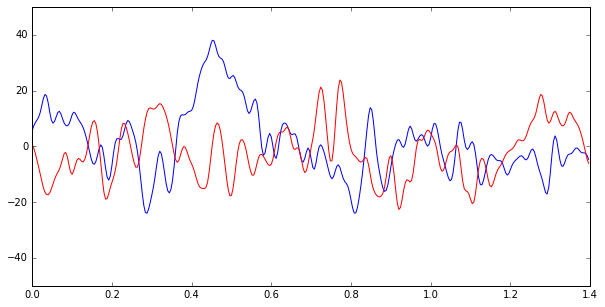

In [ ]:
# Sporedba na 6tiot kanal kaj signal koj sodrzi p300(plav) i signal koj ne sodrzi p300(crven)
fig = plt.figure(figsize=(10,5))
time = np.arange(0.0, sample_duration, 1/sample_freq)
plt.ylim([-50, 50])
plt.plot(time,tr_data[7][5],color='blue')
plt.plot(time,tr_data[1][5],color='red')
plt.show()

In [ ]:
# Funkcii za izvlekuvanje na featurite soodvetno

points = dict()
def gen_points(signal):
  for i in range(signal_length):
    points[time[i]]=signal[i]
  return points
def pos_peak(signal):
  return max(signal)
def neg_peak(signal):
  return min(signal)

# Period vo vremeto vo koj se slucil pozitivniot peak
def pos_peak_period(signal):
  points=gen_points(signal)
  pos_peak_time = [key for key in points if points[key] == pos_peak(signal)][0]
  return {pos_peak_time >= 0.0 and pos_peak_time < 0.2: 1,pos_peak_time >= 0.2 and pos_peak_time < 0.4: 2,pos_peak_time >= 0.4 and pos_peak_time < 0.6: 3,
          pos_peak_time >= 0.6 and pos_peak_time < 0.8: 4,pos_peak_time >= 0.8 and pos_peak_time < 1.0: 5,
          pos_peak_time >= 1.0 and pos_peak_time < 1.2: 6,pos_peak_time >= 1.2 and pos_peak_time < 1.4: 7}.get(True,pos_peak_time)

# Period vo vremeto vo koj se slucil negativniot peak
def neg_peak_period(signal):
  points=gen_points(signal)
  neg_peak_time = [key for key in points if points[key] == neg_peak(signal)][0]
  return {neg_peak_time >= 0.0 and neg_peak_time < 0.2: 1,neg_peak_time >= 0.2 and neg_peak_time < 0.4: 2,neg_peak_time >= 0.4 and neg_peak_time < 0.6: 3,
          neg_peak_time >= 0.6 and neg_peak_time < 0.8: 4,neg_peak_time >= 0.8 and neg_peak_time < 1.0: 5,
          neg_peak_time >= 1.0 and neg_peak_time < 1.2: 6,neg_peak_time >= 1.2 and neg_peak_time < 1.4: 7}.get(True,neg_peak_time)

# Fast fourier transform
def fft(signal):
  fft_vals = np.absolute(np.fft.rfft(signal))
  fft_freq = np.fft.rfftfreq(len(signal), 1.0/sampling_rate)
  eeg_bands = {'Delta': (0, 4),
                'Thetha': (4, 8),
                'Alpha': (8, 12),
                'Beta': (12, 30),
                'Gamma': (30, 45)}
  eeg_band_fft = dict()
  for band in eeg_bands:
      freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                        (fft_freq <= eeg_bands[band][1]))[0]
      eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
  return {'Alpha':eeg_band_fft['Alpha'],'Delta':eeg_band_fft['Delta']}
  

In [ ]:
# Funkcija za izvlekuvanje na izbranite features za dadeno trening mnozestvo
def feature_extraction(data,train_events,train_targets):
  rows_list = []
  for i in range(train_num_events):
    entry={}
    temp=0
    for j in range(num_signals):
      entry[columns[0+temp]]=pos_peak_period(data[i][j])
      entry[columns[1+temp]]=neg_peak_period(data[i][j])
      entry[columns[2+temp]]=fft(data[i][j])['Alpha']
      entry[columns[3+temp]]=fft(data[i][j])['Delta']

      temp+=4
    rows_list.append(entry)
  df = pd.DataFrame(rows_list,columns=columns) # df so obicni vredosti
  df['Object'] = train_events.astype(int)
  df['Target'] = train_targets.astype(int) # dodavanje na klasite na kraj

  return df

In [ ]:
# Diskretiziranje na dvata kanali

def discretize_channels(df):
  n = math.floor(1 + math.log(train_num_events,2)) 
  d = KBinsDiscretizer(n_bins = n, encode='ordinal', strategy='uniform')
  for c in channels:
    current_channel = df[c]
    current_channel_discretized = d.fit_transform(pd.DataFrame(current_channel))
    df[current_channel.name] = current_channel_discretized.astype(int)

  return df

In [ ]:
# Procesiranje na podatocite, izvlekuvanje features, diskretizacija i zacuvuvanje za ponatamosno koristenje
for i in range(0,15):
  train_data = loading_train_data(i+1)

  set1=train_data["S01"]
  set2=train_data["S02"]
  set3=train_data["S03"]

  data01 = reformat(set1)
  df01 = feature_extraction(data01,set1[1],set1[2])
  df01 = discretize_channels(df01)

  data02 = reformat(set2)
  df02 = feature_extraction(data02,set2[1],set2[2])
  df02 = discretize_channels(df02)

  data03 = reformat(set3)
  df03 = feature_extraction(data03,set3[1],set3[2])
  df03 = discretize_channels(df03)


  final_df = pd.concat([df01,df02,df03],ignore_index=True)
  final_df.to_csv(r'drive/My Drive/Inteligentni_Sistemi/final_train_data_'+str(i+1)+'.csv',index=False)



In [ ]:
train_df_01 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_1.csv')
train_df_02 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_2.csv')
train_df_03 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_3.csv')
train_df_04 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_4.csv')
train_df_05 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_5.csv')
train_df_06 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_6.csv')
train_df_07 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_7.csv')
train_df_08 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_8.csv')
train_df_09 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_9.csv')
train_df_10 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_10.csv')
train_df_11 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_11.csv')
train_df_12 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_12.csv')
train_df_13 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_13.csv')
train_df_14 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_14.csv')
train_df_15 = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data_15.csv')

final_train_df = pd.concat([train_df_01,train_df_02,train_df_03,train_df_04,train_df_05,train_df_06,train_df_07,train_df_08,train_df_01,train_df_09,train_df_10,train_df_11,train_df_12,train_df_13,train_df_14,train_df_15],ignore_index=True)
final_df.to_csv(r'drive/My Drive/Inteligentni_Sistemi/final_train_data.csv',index=False)

In [ ]:
# Vcituvanje na obrabotenite trening podatocite
train_df = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_train_data.csv')

In [ ]:
# Separate majority and minority classes
df_majority = train_df[train_df.Target==0]
df_minority = train_df[train_df.Target==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4200,   # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.Target.value_counts()
target = df_upsampled["Target"]
data = df_upsampled.drop('Target',axis=1).drop('Object',axis=1)
x_train,x_test,y_train,y_test = train_test_split(data,target,test_size=0.3,random_state=0)

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, alpha=1e-4,
                    solver='lbfgs', activation='logistic', verbose=True, random_state=1,
                    learning_rate_init=.2)


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    mlp.fit(x_train, y_train)


print("Training set score: " + str(mlp.score(x_train, y_train)))
print("Test set score: " + str(mlp.score(x_test,y_test)))

Training set score: 0.866156462585034
Test set score: 0.7880952380952381


In [ ]:
# Vcituvanje na raw test podatoci
def loading_test_data(subject_num):
  path="drive/My Drive/Inteligentni_Sistemi/SBJ"

  test_data_01 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S01/Test/testData.mat')['testData']
  test_events_01 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S01/Test/testEvents.txt')
  runs_per_block01 = int(np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S01/Test/runs_per_block.txt').item())

  test_data_02 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S02/Test/testData.mat')['testData']
  test_events_02 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S02/Test/testEvents.txt')
  runs_per_block02 = int(np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S02/Test/runs_per_block.txt').item())

  test_data_03 = scipy.io.loadmat(path+str(subject_num).zfill(2)+'/S03/Test/testData.mat')['testData']
  test_events_03 = np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S03/Test/testEvents.txt')
  runs_per_block03 = int(np.loadtxt(fname = path+str(subject_num).zfill(2)+'/S03/Test/runs_per_block.txt').item())


  test_data ={ "S01": (test_data_01, test_events_01, runs_per_block01),
               "S02": (test_data_02, test_events_02, runs_per_block02),
               "S03": (test_data_03, test_events_03, runs_per_block03)
               }
  return test_data

In [ ]:
# Reformat na test podatocite
def reformat_test(set_data):
  (test_data, test_events, runs_per_block) = set_data
  num_events=50*runs_per_block*evenst-per_run
  df = np.array([a[i] for i in range(0,1600) for sublist in test_data for a in sublist])
  df_1600 = np.array([df[i:i+2800] for i in range(0,len(df),2800)])
  data = np.zeros(shape=(num_events,num_signals,signal_length))
  for i in range(len(df_1600)):
    subset = df_1600[i]
    data[i] = [subset[i:i+350] for i in range(0,len(subset),signal_length)]
  
  return test_data

In [ ]:
# Funkcija za izvlekuvanje na izbranite features za dadeno test mnozestvo
def feature_extraction_test(data,test_events, num_events):
  rows_list = []
  for i in range(num_events):
    entry={}
    temp=0
    for j in range(num_signals):
      entry[columns[0+temp]]=pos_peak_period(data[i][j])
      entry[columns[1+temp]]=neg_peak_period(data[i][j])
      entry[columns[2+temp]]=fft(data[i][j])['Alpha']
      entry[columns[3+temp]]=fft(data[i][j])['Delta']

      temp+=4
    rows_list.append(entry)
  df = pd.DataFrame(rows_list,columns=columns) # df so obicni vredosti
  df['Object'] = test_events.astype(int)

  return df

In [ ]:
# Diskretiziranje na dvata kanali
def discretize_channels_test(df,num_events):
  n = math.floor(1 + math.log(num_events,2)) 
  d = KBinsDiscretizer(n_bins = n, encode='ordinal', strategy='uniform')
  for c in channels:
    current_channel = df[c]
    current_channel_discretized = d.fit_transform(pd.DataFrame(current_channel))
    df[current_channel.name] = current_channel_discretized.astype(int)

  return df

In [ ]:
# Procesiranje na podatocite, izvlekuvanje features, diskretizacija i zacuvuvanje za ponatamosno koristenje
for i in range(0,15):
  test_data = loading_test_data(i+1)

  set1=test_data["S01"]
  set2=test_data["S02"]
  set3=test_data["S03"]

  data01 = reformat_test(set1)
  df01 = feature_extraction_test(data01,set1[1],set1[2]*50*8)
  df01 = discretize_channels_test(df01,set1[2]*50*8)

  data02 = reformat_test(set2)
  df02 = feature_extraction_test(data02,set2[1],set2[2]*50*8)
  df02 = discretize_channels_test(df02,set2[2]*50*8)

  data03 = reformat_test(set3)
  df03 = feature_extraction_test(data03,set3[1],set3[2]*50*8)
  df03 = discretize_channels_test(df03,set3[2]*50*8)


  final_df = pd.concat([df01,df02,df03],ignore_index=True)
  final_df.to_csv(r'drive/My Drive/Inteligentni_Sistemi/final_test_data_'+str(i+1)+'.csv',index=False)



In [ ]:
# Funkcija za isbor na labela od predviduvanjata dobieni od modelot nad test podatocite
def get_predictions(df,runs_per_block,test_events):
  blocks_num=50
  events_num=blocks_num*runs_per_block*events_per_run

  # objects = test_events.astype(int)

  test_data = df.drop('Object',axis=1)

  predicted=mlp.predict_proba(test_data) 

  predicted=predicted.round(decimals=2)

  predicted=pd.DataFrame({'Predicted': predicted[:,1]})
  predicted['Object'] = test_events.astype(int)
  df_predictions=predicted

  predictions_np=df_predictions.to_numpy()
  temp1=np.array([predictions_np[i:i+events_per_run]for i in range(0, events_num, events_per_run)])
  predictions=np.array([temp1[i:i+runs_per_block]for i in range(0, blocks_num*runs_per_block, runs_per_block)])
  # print(predictions)

  # Gi sobirame verojatnostite po labelata za sekoj predmet 
  blocks=[]
  for i in range(0,blocks_num):
    runs=[0]*events_per_run # 8 zatoa sto ima 8 predmeti
    for j in range(0,runs_per_block):
      for k in range(0,events_per_run):
        runs[int(predictions[i][j][k][1])-1]  +=   predictions[i][j][k][0]  # gi sobira spored vrednosta na vtorata kolona ( labelata na predmetot)
      #sobira 6 verojatnosit za sekoj predmet ( 6 runs ), zatoa e pogolemo od 1 
   
    blocks.append(runs)
# blocks_prob01 # ova e 50(blocks)* 8 vrednosti-sobranite verojatnosti za sekoj predmet (od 1 do 8) od sekoj run vo toj blok

  labels=[]
  for i in range(0,blocks_num):
    m=blocks[i].index(max(blocks[i]))+1
    labels.append(m)

  return labels

In [ ]:
# Vcituvanje na obrabotenite test podatoci, predviduvanje so modelot i izbiranje na labela za sekoj blok
for i in range(0,15):
  test_data = loading_test_data(i+1)
  print(i+1)
  set1=test_data["S01"]
  set2=test_data["S02"]
  set3=test_data["S03"]

  runs_01=set1[2]
  runs_02=set2[2]
  runs_03=set3[2]

  events1=50*8*runs_01
  events2=50*8*runs_02
  events3=50*8*runs_03

  test_df = pd.read_csv('drive/My Drive/Inteligentni_Sistemi/final_test_data_'+str(i+1)+'.csv')

  df_1=test_df.iloc[0:events1]
  df_2=test_df.iloc[events1:(events1+events2)]
  df_3=test_df.iloc[(events1+events2):(events1+events2+events3)]

  labels1=get_predictions(df_1,runs_01,set1[1])

  labels3=get_predictions(df_3,runs_03,set3[1])

  labels2=get_predictions(df_2,runs_02,set2[1])

  

  print(labels1)
  print(labels2)
  print(labels3)


1
[4, 7, 4, 5, 4, 6, 4, 1, 7, 3, 1, 6, 2, 8, 8, 6, 2, 8, 5, 5, 4, 3, 7, 4, 1, 3, 3, 1, 4, 1, 6, 7, 4, 3, 7, 8, 5, 3, 6, 7, 6, 7, 2, 3, 8, 6, 8, 3, 7, 2]
[3, 5, 6, 2, 2, 6, 7, 4, 2, 6, 3, 2, 2, 8, 4, 6, 1, 7, 6, 4, 8, 6, 6, 6, 7, 5, 5, 1, 7, 6, 4, 1, 5, 7, 8, 8, 3, 7, 7, 8, 2, 5, 7, 6, 4, 7, 6, 6, 7, 2]
[2, 2, 8, 6, 7, 7, 7, 1, 5, 2, 5, 8, 6, 2, 4, 1, 6, 6, 8, 7, 1, 2, 3, 6, 1, 3, 8, 5, 2, 5, 3, 6, 8, 1, 1, 6, 2, 5, 3, 8, 3, 6, 6, 3, 3, 2, 2, 7, 6, 3]
2
[2, 5, 6, 1, 4, 1, 5, 6, 3, 5, 4, 4, 5, 5, 8, 6, 4, 5, 5, 3, 5, 4, 5, 7, 1, 5, 4, 7, 7, 8, 7, 4, 4, 1, 8, 8, 3, 4, 6, 8, 7, 6, 8, 5, 7, 2, 3, 7, 2, 8]
[3, 8, 6, 2, 1, 3, 5, 6, 4, 6, 1, 2, 3, 5, 3, 4, 4, 5, 4, 6, 5, 8, 5, 2, 2, 3, 6, 3, 3, 2, 7, 7, 7, 2, 2, 5, 8, 7, 2, 1, 5, 3, 6, 8, 2, 5, 7, 5, 2, 8]
[4, 6, 8, 6, 2, 6, 3, 1, 2, 6, 1, 1, 8, 5, 6, 6, 7, 3, 3, 3, 6, 3, 1, 2, 5, 4, 7, 7, 6, 2, 5, 4, 1, 8, 1, 3, 1, 8, 8, 4, 1, 7, 3, 5, 5, 6, 7, 5, 1, 6]
3
[7, 4, 1, 7, 7, 1, 6, 8, 6, 7, 2, 5, 8, 4, 6, 8, 5, 4, 5, 5, 4, 4, 5, 3, 6, 5, 6, 7, 4, 